In [108]:
# prelims: torchtext -c pytorch; seaborn spacy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Image, display
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
seaborn.set_context(context="talk")
%matplotlib inline

cuda


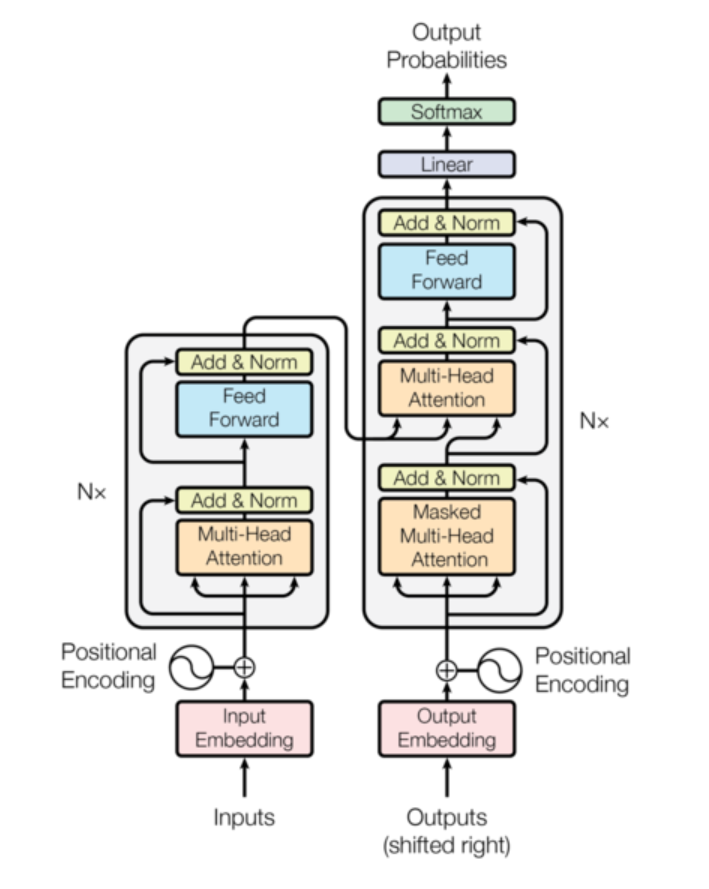

The left N layers are the encoder
The right N layers are the decoder
All layers output vectors with dimension d_model = 512


In [109]:
class EncoderDecoder(nn.Module):
    "A standard Encoder-Decoder architecture."
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        encoded = self.encode(src, src_mask) # n_input_features, n_hidden_features_1 ?
        decoded = self.decode(encoded, src_mask, tgt, tgt_mask)
        return decoded
    
    def encode(self, src, src_mask):
        embeded = self.src_embed(src)
        encoded = self.encoder(embeded, src_mask)
        return encoded
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        embeded = self.tgt_embed(tgt)
        decoded = self.decoder(embeded, memory, src_mask, tgt_mask)   


display(Image(filename='images/encoderDecoder.png', width=300))
print("The left N layers are the encoder\nThe right N layers are the decoder\nAll layers output vectors with dimension d_model = 512")

In [110]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        out = self.proj(x)
        out = F.log_softmax(out, dim=-1)
        return out

In [111]:
def clones(module, N):
    "Produce N identical layers."
    modules = [copy.deepcopy(module) for _ in range(N)]
    return nn.ModuleList(modules)

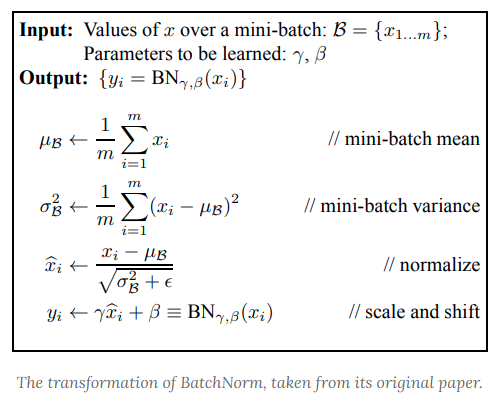

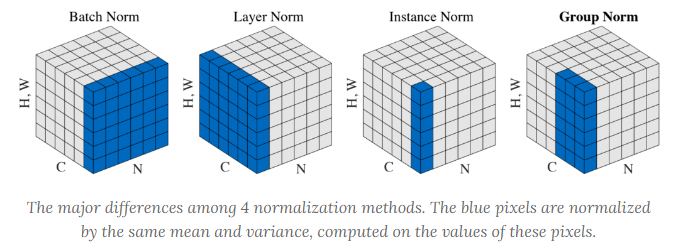

LayerNorm is like BatchNorm but in different direction


In [112]:
class LayerNorm(nn.Module):
    "Construct a layernorm module. (Vector normalization for a layer)"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features), requires_grad=True)
        self.b_2 = nn.Parameter(torch.zeros(features), requires_grad=True)
        self.eps = eps
        "a_2, b_2 are for scaling and shifting"
        "a_2 starts at 1 and b_2 starts at 0"
        "They are the norm weights to train"

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std  = x.std (-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
display(Image(filename='images/batchNorm.png', width=400))
display(Image(filename="images/norms.png", width=400))
print("LayerNorm is like BatchNorm but in different direction")

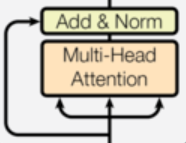

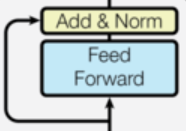

LayerNorm(x + MultiHeadAttention(x))
LayerNorm(x + FeedForward(x))


In [113]:
"""
LayerNorm is used in 4 places:
1. Residual Connection of MultiHeadAttention: LayerNorm(x + MultiHeadAttention(x))
2. Residual Connection of FeedForward: LayerNorm(x + FeedForward(x))
3. Normalization after N layers of Encoder: LayerNorm(Encoder(x))
4. Normalization after N layers of Decoder: LayerNorm(Decoder(x))
"""
display(Image(filename='images/attentionResidual.png', width=200))
display(Image(filename="images/feedResidual.png", width=200))
print("LayerNorm(x + MultiHeadAttention(x))\nLayerNorm(x + FeedForward(x))")

In [114]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm
    LayerNorm(x + dropout(Sublayer(x)))
    Sublayer can be MultiHeadAttention or FeedForward
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        out = self.norm(x) # This norm is the LayerNorm of previous sublayer
        out = sublayer(out)
        out = self.dropout(x)
        out = out + x # Residual connection
        return out

In [115]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        out = x
        for layer in self.layers:
            out = layer(out, mask)
        out = self.norm(out) # normalize after N layers
        return out

In [116]:
class EncoderLayer(nn.Module):
    """
    Each encoder layer has 2 sub-layers
    1. self-attention
    2. feed forward
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow EncoderLayer shown on the left of the model architecture figure."
        self_attn_layer = lambda x: self._attn(x, x, x, mask) # query, key, value, mask
        out = self.sublayer[0](x,   self_attn_layer)
        out = self.sublayer[1](out, self.feed_forward)
        return out

In [117]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        out = x
        for layer in self.layers:
            out = layer(out, memory, src_mask, tgt_mask)
        out = self.norm(out) # normalize after N layers
        return out

In [118]:
class DecoderLayer(nn.Module):
    """
    Each encoder layer has 3 sub-layers
    1. self-attention
    2. source-attention
    3. feed forward
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow DecoderLayer shown on the right of the model architecture figure."
        m = memory
        self_attn_layer = lambda x: self.self_attn(x, x, x, tgt_mask)
        src_attn_layer  = lambda x: self.src_attn (x, m, m, src_mask)
        out = self.sublayer[0](x, self_attn_layer)
        out = self.sublayer[1](out, src_attn_layer)
        out = self.sublayer[2](out, self.feed_forward)
        return out

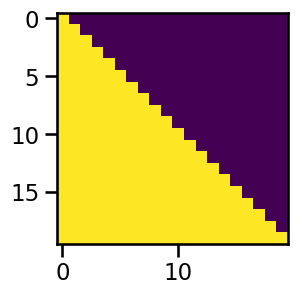

It shows the position each tgt word (row) 
is only allowed to look at (column) where 
the word is shown at or before it.

row 0 can only see col 0, not col 1-20.


In [119]:
"""
We also modify the self-attention sub-layer in the decoder stack to prevent positions 
from attending to subsequent positions. This masking, combined with fact that the output 
embeddings are offset by one position, ensures that the predictions for position i can 
depend only on the known outputs at positions less than i.
"""
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
plt.figure(figsize=(3,3))
plt.imshow(subsequent_mask(20)[0])
plt.show()
print("It shows the position each tgt word (row) \n" + 
      "is only allowed to look at (column) where \n" +
      "the word is shown at or before it.\n")

print("row 0 can only see col 0, not col 1-20.")

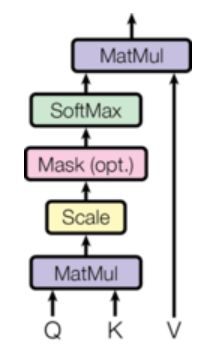

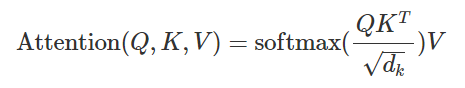

In [120]:
"""
Attention: (Scaled Dot-Product Attention)
A function takes in 3 input vectors Query, Key, Value and output 1 vector.

It maps a query and a set of key-value pairs to an output. The output is 
computed as a weighted sum of the values, where the weight assigned to 
each value is computed by a compatibility function of the query with the 
corresponding key.

We compute the dot products of the query with all keys, divide each by
sqrt(d_k), dimension of key. Then apply softmax.

Dividing by sqrt(d_k) is to prevent Q dot K to be large where Q and K
can be seen as random variables of 0 mean and variance 1.
"""
display(Image(filename='images/attentionFlow.png', width=150))
display(Image(filename="images/attentionEqn.png", width=300))

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # negative inf num to make softmax 0

    p_attn = F.softmax(scores, dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn # keeps Q dot K
    

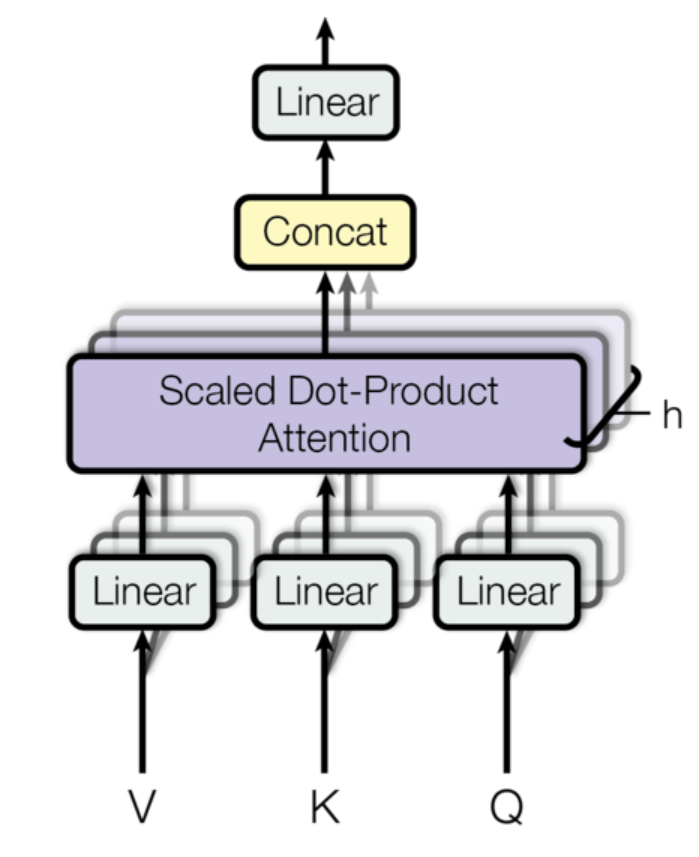

In [121]:
"""
Multi Head Attention

Set h = 8 parallel attention layers, or heads.

Linear transform Q K V to 8 different vectors to do 8 attention,
and combine the vectors at the end.
"""
display(Image(filename='images/multiHeadAttentionFlow.png', width=300))

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # Assume d_k always equal d_v
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implement the multi headed attention shown in the flow figure above."
        if mask is not None:
            # Same mask applied to all h heads.
            # unsqueeze([1, 2, 3], 0) = [[1, 2, 3]]
            # unsqueeze([1, 2, 3], 1) = [[1], [2], [3]]
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        # zip puts vectors together as tuples [(q_0, k_0, v_0), (q_1, k_1, v_1), ...]
        # use linears[0], linears[1], linears[2] for Q, K, V
        # each linears[l] is d_model x d_model for multi head?
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip (self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # use linears[3]


In [122]:
"""
Attention use cases in the model:

1) In “encoder-decoder attention” layers:
prev decoder output -> curr query
prev encoder output -> curr key
prev encoder output -> curr value

2) In "self-attention" layers of encoder:
prev encoder output -> curr query
prev encoder output -> curr key
prev encoder output -> curr value

3) In "self-attention" layers of decoder:
prev decoder output -> curr query
prev decoder output -> curr key
prev decoder output -> curr value
Use mask to preserve the auto-regressive property where a word can only compares
to a word that appears before or equal to the word.
"""

'\nAttention use cases in the model:\n\n1) In “encoder-decoder attention” layers:\nprev decoder output -> curr query\nprev encoder output -> curr key\nprev encoder output -> curr value\n\n2) In "self-attention" layers of encoder:\nprev encoder output -> curr query\nprev encoder output -> curr key\nprev encoder output -> curr value\n\n3) In "self-attention" layers of decoder:\nprev decoder output -> curr query\nprev decoder output -> curr key\nprev decoder output -> curr value\nUse mask to preserve the auto-regressive property where a word can only compares\nto a word that appears before or equal to the word.\n'

In [123]:
class PositionwiseFeedForward(nn.Module):
    """
    Implements FFN equation.
    It contains 2 linear transformations and a ReLU activation in between
    
    FFN(x) = max(0, x W_1 + b_1) W_2 + b_2
    W_1, b_1: first linear trans
    max: relu
    W_2, b_2: second linear trans

    For FFN, input and output dimension is d_model = 512
    However, the inner-layer has dimension of d_ff = 2048
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w_2(x)
        return x

In [124]:
class Embeddings(nn.Module):
    """
    Embedding layer is a dimension reduction layer to turn a word (vocab)
    into a vector of d_model so it can be taken by the encoder-decoder
    neural network. This initial layer also multiply the weights by
    sqrt(d_model).
    """
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        x = self.lut(x)
        x = x * math.sqrt(self.d_model)
        return x

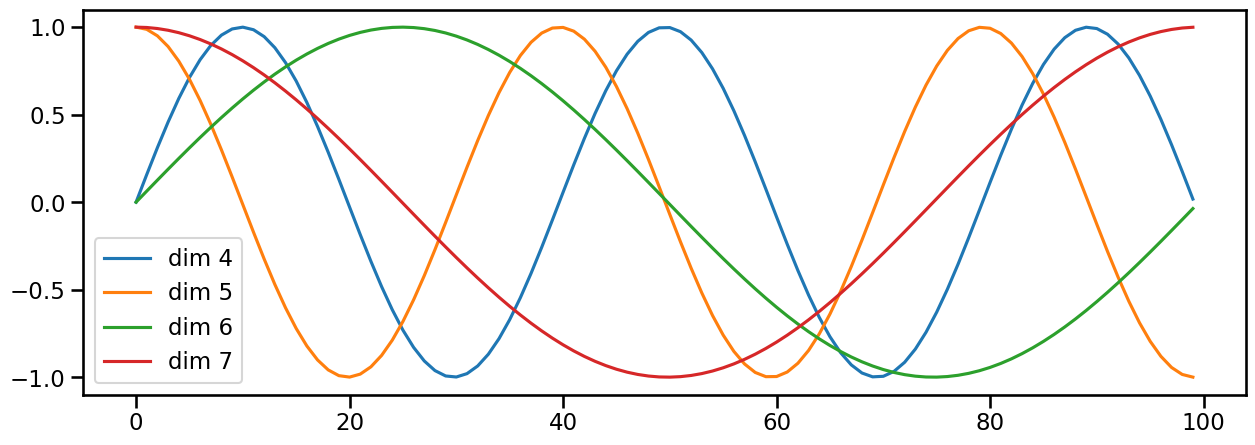

In [125]:
class PositionalEncoding(nn.Module):
    """
    The PE function is chosen to encode the position of words (vocabs) as
    it is assume that "relative position" can be easily learned by the PE
    function.

    PE(pos, 2i)   = sin (pos / 10000^(2i / d_model))
    PE(pos, 2i+1) = cos (pos / 10000^(2i / d_model))
    pos: position to encode, i: dimension
    """
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        x = self.dropout(x)
        return x

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4, 5, 6, 7]])
plt.show()

In [142]:
"Full model"

def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    dc = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    posEnc = PositionalEncoding(d_model, dropout)

    encoderLayer = EncoderLayer(d_model, dc(attn), dc(ff), dropout)
    decoderLayer = DecoderLayer(d_model, dc(attn), dc(attn), dc(ff), dropout)
    src_embedding = Embeddings(d_model, src_vocab)
    tgt_embedding = Embeddings(d_model, tgt_vocab)

    encoder = Encoder(encoderLayer, N)
    decoder = Decoder(decoderLayer, N)
    src_embedding_pos_encoding = nn.Sequential(src_embedding, dc(posEnc))
    tgt_embedding_pos_encoding = nn.Sequential(tgt_embedding, dc(posEnc))
    generator = Generator(d_model, tgt_vocab)

    model = EncoderDecoder(encoder, decoder, src_embedding_pos_encoding, tgt_embedding_pos_encoding, generator)

    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return model

# Small example model
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/trans1")
tmp_model = make_model(10, 10, 2)
#writer.add_graph(tmp_model, torch.tensor([0, 0]).to(device))
#writer.close()